In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import healpy as hp
import pickle as pl
from tqdm import tqdm
from scipy.optimize import minimize
import emcee
import corner
from getdist import plots, MCSamples
sys.path.append('../')

In [2]:
import binning 

In [3]:
binner = binning.multipole_binning(30,lmin=2,lmax=1024)
def bin_cell(arr):
    return binning.binning(arr,binner)

In [4]:
path = '../Data/paper/recFG.pkl'

In [5]:
dat = pl.load(open(path,'rb'))

In [6]:
l = dat['B']

In [7]:
dat.keys()

dict_keys(['nofg_cl', 'fg2_cl', 'fid', 'fidm', 'NOFG-MCN0', 'fg1-MCN0', 'fg2-MCN0', 'NOFG-MCER', 'fg2-MCER', 'NOFG-MF', 'fg2-MF', 'B'])

In [23]:
dat1 = dat['nofg_cl']
dat2 = dat['fg2_cl']

In [8]:
std1 = dat['nofg_cl'].std(axis=0)
std2 = dat['fg2_cl'].std(axis=0)

In [46]:
cov1 = np.cov(dat['nofg_cl'].T)
cov2 = np.cov(dat['fg2_cl'].T)

In [11]:
n0_nofg = dat['NOFG-MCN0']
n0_fg1 = dat['fg1-MCN0']
n0_fg2 = dat['fg2-MCN0']

In [15]:
b = dat['B']

In [16]:
fid = dat['fid']

In [17]:
n0_nofg_b = bin_cell(n0_nofg)
n0_fg1_b = bin_cell(n0_fg1)
n0_fg2_b = bin_cell(n0_fg2)

In [79]:
d_fg1 = n0_fg1_b-n0_nofg_b
d_fg2 = n0_fg2_b-n0_nofg_b

In [42]:
def chi_sq(alens,cl,which):
    dcl = cl - (alens*fid)
    if which == 0:
        cov = cov1
    elif (which == 1) or (which == 2):
        cov = cov2
    return np.dot(dcl,np.dot(np.linalg.inv(cov),dcl))

In [43]:
def log_prior(theta):
    if 0.5 < theta < 1.5:
        return 0.0
    return -np.inf

def log_likelihood(theta,cl,which):
    return -0.5 * chi_sq(theta,cl,which)

def log_probability(theta,cl,which):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,cl,which)

In [55]:
def get_samples(which,cl):
    pos = [1] + 1e-1 * np.random.randn(64, 1)
    nwalkers,ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(cl,which) )
    sampler.run_mcmc(pos, 2000, progress=True)
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    return flat_samples

In [56]:
nofg_samp = get_samples(0,dat1.mean(axis=0))

100%|██████████| 2000/2000 [00:05<00:00, 352.70it/s]


In [57]:
fg2_samp = get_samples(2,dat2.mean(axis=0))

100%|██████████| 2000/2000 [00:05<00:00, 342.04it/s]


In [71]:
fg2_dn0_samp = get_samples(2,dat2.mean(axis=0)+d_fg2)

100%|██████████| 2000/2000 [00:05<00:00, 345.90it/s]


In [83]:
fg1_dn0_samp = get_samples(2,dat2.mean(axis=0)+d_fg1)

100%|██████████| 2000/2000 [00:05<00:00, 352.13it/s]


In [84]:
nofg_mc =  MCSamples(samples=nofg_samp,names=['Alens'], label='No FG')
fg2_mc = MCSamples(samples=fg2_samp,names=['Alens'],label='FG 2')
fg2_dn0_mc = MCSamples(samples=fg2_dn0_samp,names=['Alens'],label='FG 2')
fg1_dn0_mc = MCSamples(samples=fg1_dn0_samp,names=['Alens'],label='FG 2')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


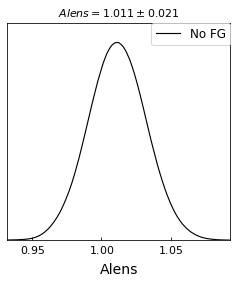

In [67]:
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot([nofg_mc], ['Alens'],legend_labels=['No FG'],title_limit=1)

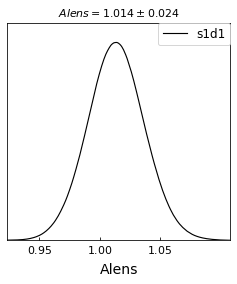

In [68]:
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot([fg2_mc], ['Alens'],legend_labels=['s1d1'],title_limit=1)

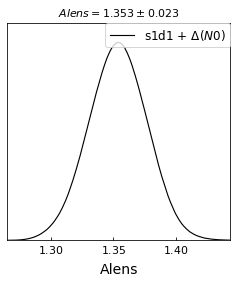

In [82]:
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot([fg2_dn0_mc], ['Alens'],legend_labels=['s1d1 + $\Delta(N0)$'],title_limit=1)

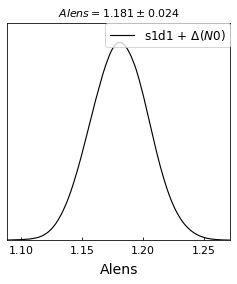

In [85]:
g = plots.get_subplot_plotter(width_inch=4)
g.triangle_plot([fg1_dn0_mc], ['Alens'],legend_labels=['s1d1 + $\Delta(N0)$'],title_limit=1)